In [1]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

In [2]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'

In [3]:
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)

In [4]:
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


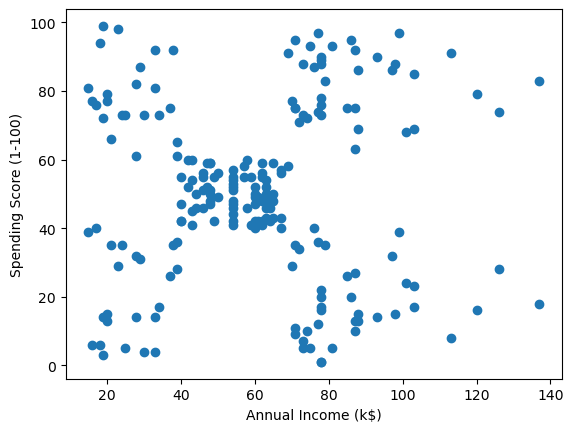

In [6]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

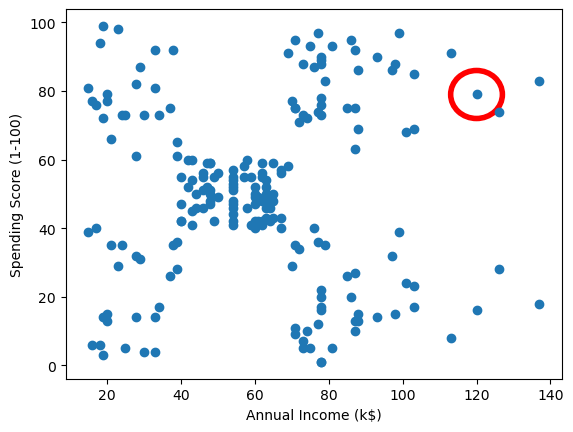

In [7]:
ex_pt = random.randint(0, 199)
from matplotlib.patches import Circle
circle1 = Circle((x[ex_pt], y[ex_pt]), 7, color='r', fill=False, linewidth=4)
fig, ax = plt.subplots()
ax.add_artist(circle1)
ax.scatter(x,y)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
plt.show()
plt.show()

## Explore the Neighborhood

Convert Dataframe to pytorch

In [8]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

Define a threshold radius and a minimum sample

In [9]:
rad = 7.
min_sample = 5

Euclidean Distance between a single x,y coordinate and every other point

Grab any indexes where the distance is less than or equal to radius

Apply indexes

In [10]:
def pt_neighborhood(pt_idx, tens, rad=7.):
    dist = ((tens - tens[pt_idx])**2).sqrt().sum(1)
    return tens[(dist <= rad)]

In [11]:
pt_neighborhood(ex_pt, x_y_tens)

tensor([[120.,  79.]], device='cuda:0', dtype=torch.float64)

## Find Core Points

Check each point in neighborhood and see if it's own neighborhood is >= num_sample

In [12]:
ex_pt_neighborhood = pt_neighborhood(ex_pt, x_y_tens)

In [13]:
ex_pt_neighborhood

tensor([[120.,  79.]], device='cuda:0', dtype=torch.float64)

In [14]:
ex_pt_neighborhood[0]

tensor([120.,  79.], device='cuda:0', dtype=torch.float64)

In [15]:
int(x_y_tens.eq(ex_pt_neighborhood[0]).all(dim=1).nonzero())

195

In [16]:
x_y_tens[135]

tensor([73., 88.], device='cuda:0', dtype=torch.float64)

## Find All Core Points

In [17]:
core_pts = []
non_core_pts = []
for i, pt in enumerate(x_y_tens):
    # test to see if point is core point
    neighborhood = pt_neighborhood(i, x_y_tens)
    if neighborhood.shape[0] >= min_sample:
        # create a boolean tensor to find indexes as integers and append to list
        core_pts.append(x_y_tens[i])
        print(f"{pt} is in the neighborhood")

    else:
        # create a boolean tensor to find indexes as integers and append to list
        non_core_pts.append(x_y_tens[i])
        print(f"{pt} is not in the neighborhood")

core_pts = torch.stack(core_pts)
non_core_pts = torch.stack(non_core_pts)

tensor([15., 39.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([15., 81.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([16.,  6.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([16., 77.], device='cuda:0', dtype=torch.float64) is in the neighborhood
tensor([17., 40.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([17., 76.], device='cuda:0', dtype=torch.float64) is in the neighborhood
tensor([18.,  6.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([18., 94.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([19.,  3.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([19., 72.], device='cuda:0', dtype=torch.float64) is in the neighborhood
tensor([19., 14.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([19., 99.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tens

In [18]:
core_pts

tensor([[16., 77.],
        [17., 76.],
        [19., 72.],
        [20., 77.],
        [20., 79.],
        [39., 61.],
        [40., 55.],
        [40., 47.],
        [40., 42.],
        [40., 42.],
        [42., 52.],
        [42., 60.],
        [43., 54.],
        [43., 60.],
        [43., 45.],
        [43., 41.],
        [44., 50.],
        [44., 46.],
        [46., 51.],
        [46., 46.],
        [46., 56.],
        [46., 55.],
        [47., 52.],
        [47., 59.],
        [48., 51.],
        [48., 59.],
        [48., 50.],
        [48., 48.],
        [48., 59.],
        [48., 47.],
        [49., 55.],
        [49., 42.],
        [50., 49.],
        [50., 56.],
        [54., 47.],
        [54., 54.],
        [54., 53.],
        [54., 48.],
        [54., 52.],
        [54., 42.],
        [54., 51.],
        [54., 55.],
        [54., 41.],
        [54., 44.],
        [54., 57.],
        [54., 46.],
        [57., 58.],
        [57., 55.],
        [58., 60.],
        [58., 46.],


## Pick a Random Core Point

In [19]:
cluster_init = random.randint(0, core_pts.shape[0])

In [20]:
core_pts[cluster_init][0].detach().cpu().numpy()

array(62.)

In [21]:
neighborhood = pt_neighborhood(cluster_init, core_pts)

In [22]:
neighborhood

tensor([[59., 41.],
        [60., 40.],
        [60., 42.],
        [61., 42.],
        [62., 41.],
        [62., 48.],
        [62., 42.],
        [63., 46.],
        [63., 43.],
        [64., 42.],
        [64., 46.],
        [65., 43.],
        [67., 43.],
        [67., 40.]], device='cuda:0', dtype=torch.float64)

In [23]:
core_pts - neighborhood[0]

tensor([[-43.,  36.],
        [-42.,  35.],
        [-40.,  31.],
        [-39.,  36.],
        [-39.,  38.],
        [-20.,  20.],
        [-19.,  14.],
        [-19.,   6.],
        [-19.,   1.],
        [-19.,   1.],
        [-17.,  11.],
        [-17.,  19.],
        [-16.,  13.],
        [-16.,  19.],
        [-16.,   4.],
        [-16.,   0.],
        [-15.,   9.],
        [-15.,   5.],
        [-13.,  10.],
        [-13.,   5.],
        [-13.,  15.],
        [-13.,  14.],
        [-12.,  11.],
        [-12.,  18.],
        [-11.,  10.],
        [-11.,  18.],
        [-11.,   9.],
        [-11.,   7.],
        [-11.,  18.],
        [-11.,   6.],
        [-10.,  14.],
        [-10.,   1.],
        [ -9.,   8.],
        [ -9.,  15.],
        [ -5.,   6.],
        [ -5.,  13.],
        [ -5.,  12.],
        [ -5.,   7.],
        [ -5.,  11.],
        [ -5.,   1.],
        [ -5.,  10.],
        [ -5.,  14.],
        [ -5.,   0.],
        [ -5.,   3.],
        [ -5.,  16.],
        [ 

In [24]:
core_pts

tensor([[16., 77.],
        [17., 76.],
        [19., 72.],
        [20., 77.],
        [20., 79.],
        [39., 61.],
        [40., 55.],
        [40., 47.],
        [40., 42.],
        [40., 42.],
        [42., 52.],
        [42., 60.],
        [43., 54.],
        [43., 60.],
        [43., 45.],
        [43., 41.],
        [44., 50.],
        [44., 46.],
        [46., 51.],
        [46., 46.],
        [46., 56.],
        [46., 55.],
        [47., 52.],
        [47., 59.],
        [48., 51.],
        [48., 59.],
        [48., 50.],
        [48., 48.],
        [48., 59.],
        [48., 47.],
        [49., 55.],
        [49., 42.],
        [50., 49.],
        [50., 56.],
        [54., 47.],
        [54., 54.],
        [54., 53.],
        [54., 48.],
        [54., 52.],
        [54., 42.],
        [54., 51.],
        [54., 55.],
        [54., 41.],
        [54., 44.],
        [54., 57.],
        [54., 46.],
        [57., 58.],
        [57., 55.],
        [58., 60.],
        [58., 46.],


In [25]:
def core_neighborhood(pt_idx, tens, n_tens, rad=7.):
    dist = ((tens - n_tens[pt_idx])**2).sqrt().sum(1)
    return tens[(dist <= rad)]

In [26]:
first_cluster_core = []
for i, pt in enumerate(neighborhood):
    neighborhood_core = core_neighborhood(i, core_pts, neighborhood)
    first_cluster_core.append(neighborhood[i])

first_cluster_core = torch.stack(first_cluster_core)
first_cluster_core = torch.unique(first_cluster_core, dim=0)

In [27]:
first_cluster_core

tensor([[59., 41.],
        [60., 40.],
        [60., 42.],
        [61., 42.],
        [62., 41.],
        [62., 42.],
        [62., 48.],
        [63., 43.],
        [63., 46.],
        [64., 42.],
        [64., 46.],
        [65., 43.],
        [67., 40.],
        [67., 43.]], device='cuda:0', dtype=torch.float64)

In [31]:
def n_expand(neighborhood):
    cluster_pts = []
    for i, pt in enumerate(neighborhood):
        neighborhood_core = core_neighborhood(i, core_pts, neighborhood)
        cluster_pts.append(neighborhood_core)
    cluster_pts = torch.stack(cluster_pts)
    cluster_pts = torch.unique(cluster_pts, dim=0)    
    return cluster_pts

In [32]:
n_expand(first_cluster_core)

RuntimeError: stack expects each tensor to be equal size, but got [12, 2] at entry 0 and [11, 2] at entry 1

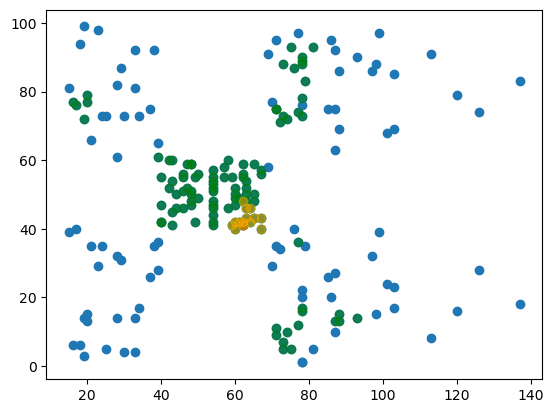

In [33]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.scatter(core_pts[cluster_init][0].detach().cpu().numpy(), core_pts[cluster_init][1].detach().cpu().numpy(), color='red')
ax.scatter(core_pts[:,0].detach().cpu().numpy(), core_pts[:,1].detach().cpu().numpy(), color='green', alpha=0.5)
ax.scatter(first_cluster_core[:,0].detach().cpu().numpy(), first_cluster_core[:,1].detach().cpu().numpy(), color='orange', alpha=0.5)

In [ ]:
torch.stack(first_cluster_core)

In [ ]:
def plot_cluster(init_pt, core_pts, )
circle1 = Circle((x_y_tens[ex_pt, 0], x_y_tens[ex_pt, 1]), rad, color='red', fill=False, linewidth=4)
circle2 = Circle((x_y_tens[ex_pt, 0], x_y_tens[ex_pt, 1]), rad, color='green', linewidth=4, alpha=0.5)
fig, ax = plt.subplots()
for coord in range(ex_neighborhood.shape[0]):
    x = int(ex_neighborhood[coord, 0])
    y = int(ex_neighborhood[coord, 1])
    fill_circle = Circle((x, y), rad, color="orange", linewidth=2)
    rad_circle = Circle((x, y), rad, color="red", fill=False, linewidth=4)
    ax.add_artist(fill_circle)
    ax.add_artist(rad_circle)
x = list(x_y_tens[:,0].detach().cpu().numpy())
y = list(x_y_tens[:,1].detach().cpu().numpy())
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.scatter(x,y)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
plt.show()
plt.show()